Setting up pulse simulator:

1) switch to openpulse-sim branch of qiskit-aer, also include this pull request https://github.com/Qiskit/qiskit-aer/pull/451 and increase `nsteps` in qiskit-aer/qiskit/providers/aer/openpulse/solver/options.py (I upped 100x to 50000)

2) run `python setup.py build_ext --inplace`

3) `python ./setup.py bdist_wheel`

4) `cd dist` and `pip install` the wheel

5) `rm -rf /Users/pranavgokhale/anaconda3/envs/QiskitDevenv/lib/python3.7/site-packages/qiskit` (replace with your username / site-packages location)

6) `ln -s /Users/pranavgokhale/Developer/qiskit/qiskit-aer/qiskit/ /Users/pranavgokhale/anaconda3/envs/QiskitDevenv/lib/python3.7/site-packages/qiskit` (tailor paths to your setup)

In [117]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [118]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib
from qiskit.test.mock import FakeAlmaden
from qiskit.ignis.verification.tomography.data import marginal_counts

In [ ]:
import pulse_compiler_helper_fns

In [4]:
backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
back_config = backend.configuration().to_dict()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [39]:
hamiltonian = {}
hamiltonian['h_str'] = ['_SUM[i,0,1,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,1,omegad{i}*X{i}||D{i}]',
                        'jq0q1*Sp0*Sm1', 'jq0q1*Sm0*Sp1', 'omegad1*X0||U0', 'omegad0*X1||U1']
hamiltonian['qub'] = {'0': 2, '1': 2}
hamiltonian['vars'] = {'wq0': 30.518812656662774, 'wq1': 31.238229295532093,
                       'omegad0': 0.1675, 'omegad1': 2*np.pi*0.02,
                       'jq0q1': 0.01}

back_config['hamiltonian'] = hamiltonian
back_config['noise'] = {}
back_config['dt'] = 1.0
back_config['ode_options'] = {}
back_config['qubit_list'] = [0,1]

In [40]:
schedules = []
thetas = np.linspace(0, np.pi, 41)
for theta in thetas:
    for basis in ['X', 'Y', 'Z']:
        circuit = q.QuantumCircuit(1)
        circuit.rx(theta, 0)
        decomposed_circuit = circuit.decompose()
        pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
        transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
        schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
        if basis == 'Y':  # apply H Sdag
            schedule |= cmd_def.get('u1', qubits=[0], P0=-np.pi/2) << schedule.duration
            schedule |= cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) << schedule.duration
        elif basis == 'X':  # apply H
            schedule |= cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) << schedule.duration
        schedule |= measure << schedule.duration
        schedules.append(schedule)

We have to do this step twice to get the dressed frequencies for setting the LO's. Note here that we set `meas_level=1` and `meas_return=avg` which will return the average probability for the qubit to be in the |1> state.

In [42]:
shots = 10000

In [43]:
qobj = q.assemble(schedules, backend, 
                       meas_level=1, meas_return='avg', 
                       memory_slots=2,
                       shots=shots, sim_config = back_config)

In [44]:
evals, estates = backend_sim.get_dressed_energies(rabi_qobj)
evals/2/np.pi

array([0.        , 4.85719783, 4.97174068, 9.82893851])

In [45]:
qobj = q.assemble(schedules, backend, 
                       qubit_lo_freq = [evals[1]/2/np.pi, evals[3]/2/np.pi],
                       shots=shots, sim_config = back_config)

In [46]:
sim_result = backend_sim.run(qobj).result()

In [47]:

xs, ys, zs = [], [], []
for i in range(len(thetas)):
    x_counts = marginal_counts(sim_result.get_counts(3 * i), meas_qubits=[0])
    y_counts = marginal_counts(sim_result.get_counts(3 * i + 1), meas_qubits=[0])
    z_counts = marginal_counts(sim_result.get_counts(3 * i + 2), meas_qubits=[0])
    
    x = (x_counts.get('0', 0) / shots - 0.5) * 2
    y = (y_counts.get('0', 0) / shots - 0.5) * 2
    z = (z_counts.get('0', 0) / shots - 0.5) * 2
    print(thetas[i], x, y, z)

0.0 0.022199999999999998 0.010399999999999965 1.0
0.07853981633974483 0.019200000000000106 -0.07740000000000002 0.9974000000000001
0.15707963267948966 0.008799999999999919 -0.14080000000000004 0.9872000000000001
0.23561944901923448 0.011400000000000077 -0.22519999999999996 0.9734
0.3141592653589793 0.012399999999999967 -0.30279999999999996 0.9530000000000001
0.39269908169872414 0.0038000000000000256 -0.388 0.921
0.47123889803846897 0.0041999999999999815 -0.4386 0.8839999999999999
0.5497787143782138 0.02740000000000009 -0.5004 0.8575999999999999
0.6283185307179586 -0.009600000000000053 -0.5636 0.808
0.7068583470577035 0.02079999999999993 -0.628 0.75
0.7853981633974483 0.017800000000000038 -0.6996 0.704
0.8639379797371931 0.014399999999999968 -0.7424 0.6424000000000001
0.9424777960769379 0.008199999999999985 -0.8068 0.5952
1.0210176124166828 0.005800000000000027 -0.8513999999999999 0.5307999999999999
1.0995574287564276 0.0129999999999999 -0.8878 0.4618
1.1780972450961724 -0.0125999999999

In [119]:
import qutip
from qutip import *
from colour import Color
green = Color("green")
colors = list(green.range_to(Color("#CC6600"),41))
colors = [color.get_hex_l() for color in colors]

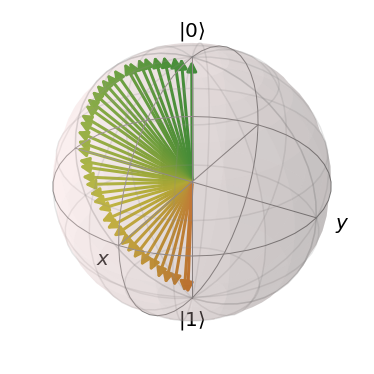

In [120]:
data = """0.0 0.022199999999999998 0.010399999999999965 1.0
0.07853981633974483 0.019200000000000106 -0.07740000000000002 0.9974000000000001
0.15707963267948966 0.008799999999999919 -0.14080000000000004 0.9872000000000001
0.23561944901923448 0.011400000000000077 -0.22519999999999996 0.9734
0.3141592653589793 0.012399999999999967 -0.30279999999999996 0.9530000000000001
0.39269908169872414 0.0038000000000000256 -0.388 0.921
0.47123889803846897 0.0041999999999999815 -0.4386 0.8839999999999999
0.5497787143782138 0.02740000000000009 -0.5004 0.8575999999999999
0.6283185307179586 -0.009600000000000053 -0.5636 0.808
0.7068583470577035 0.02079999999999993 -0.628 0.75
0.7853981633974483 0.017800000000000038 -0.6996 0.704
0.8639379797371931 0.014399999999999968 -0.7424 0.6424000000000001
0.9424777960769379 0.008199999999999985 -0.8068 0.5952
1.0210176124166828 0.005800000000000027 -0.8513999999999999 0.5307999999999999
1.0995574287564276 0.0129999999999999 -0.8878 0.4618
1.1780972450961724 -0.012599999999999945 -0.9154 0.3817999999999999
1.2566370614359172 0.006999999999999895 -0.9484 0.3062
1.335176877775662 0.0036000000000000476 -0.966 0.23960000000000004
1.413716694115407 0.012399999999999967 -0.9862 0.1581999999999999
1.4922565104551517 -0.0011999999999999789 -0.996 0.06679999999999997
1.5707963267948966 0.006599999999999939 -1.0 0.0041999999999999815
1.6493361431346414 -0.0033999999999999586 -0.9988 -0.09919999999999995
1.7278759594743862 -0.0031999999999999806 -0.9898 -0.15059999999999996
1.806415775814131 -0.0036000000000000476 -0.9748 -0.2378
1.8849555921538759 -0.010399999999999965 -0.9538 -0.3032
1.9634954084936207 -0.0232 -0.9299999999999999 -0.38739999999999997
2.0420352248333655 -0.01959999999999995 -0.8992 -0.45099999999999996
2.1205750411731104 -0.03620000000000001 -0.8674 -0.5182
2.199114857512855 -0.007800000000000029 -0.8212 -0.5964
2.2776546738526 -0.010399999999999965 -0.7678 -0.6432
2.356194490192345 -0.01980000000000004 -0.7206 -0.7090000000000001
2.4347343065320897 -0.015599999999999947 -0.6502 -0.7604
2.5132741228718345 -0.01639999999999997 -0.5920000000000001 -0.8058
2.5918139392115793 -0.019000000000000017 -0.5376000000000001 -0.8504
2.670353755551324 -0.013399999999999967 -0.46919999999999995 -0.8948
2.748893571891069 -0.030399999999999983 -0.392 -0.9178
2.827433388230814 -0.01319999999999999 -0.3104 -0.9518
2.9059732045705586 -0.0050000000000000044 -0.24 -0.9724
2.9845130209103035 -0.025399999999999978 -0.17320000000000002 -0.9872
3.0630528372500483 -0.01539999999999997 -0.0776 -0.997
3.141592653589793 -0.015199999999999991 -0.046599999999999975 -1.0""".split()

b = Bloch()
b.vector_color=colors
xs, zs = [], []
while len(data) > 0:
    data.pop(0)
    x, y, z = float(data.pop(0)), float(data.pop(0)), float(data.pop(0))
    norm = np.sqrt(x**2 + y**2 + z**2)
    x, y, z = x / norm, y / norm, z / norm
    xs.append(x); zs.append(z)
    b.add_vectors([x, y, z])
b.show()

In [112]:
b.save('Figures/drag_trajectory_bloch_sphere_SIMULATED.svg')

In [136]:
from scipy.optimize import curve_fit
fit_func = lambda z, A, w: A * np.sin((-1-z) * w)

fitparams, conv = curve_fit(fit_func, zs, xs, [0.1, np.pi])
fit_xs = [fit_func(z, *fitparams) for z in zs]

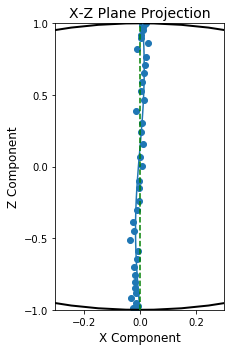

In [143]:
fig, ax = plt.subplots(figsize=(3.5, 5.27))
plt.gcf().subplots_adjust(left=0.23)
plt.scatter(xs, zs)
plt.axis([-0.3, 0.3, -1, 1])
plt.plot(fit_xs, zs)
plt.xlabel('X Component', fontsize=12)
plt.ylabel('Z Component', fontsize=12)
plt.title('X-Z Plane Projection', fontsize=14)
plt.xticks([-0.2, 0, .2])
plt.yticks([-1, -.5, 0, .5, 1])

plt.plot([0, 0], [-1, 1], 'g--')

circle1 = plt.Circle((0, 0), 1, fill=False, linewidth=2)
plt.gcf().gca().add_artist(circle1)
plt.savefig('Figures/drag_trajectory_2d_SIMULATED.svg')

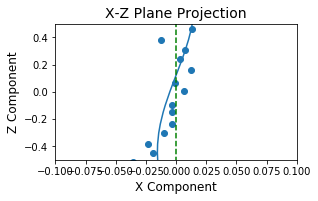

In [155]:
fig, ax = plt.subplots(figsize=(5, 2.5))
plt.gcf().subplots_adjust(left=0.23)
plt.scatter(xs, zs)
plt.axis([-0.1, 0.1, -0.5, 0.5])
plt.plot(fit_xs, zs)
plt.xlabel('X Component', fontsize=12)
plt.ylabel('Z Component', fontsize=12)
plt.title('X-Z Plane Projection', fontsize=14)

plt.plot([0, 0], [-1, 1], 'g--')

circle1 = plt.Circle((0, 0), 1, fill=False, linewidth=2)
plt.gcf().gca().add_artist(circle1)
plt.savefig('Figures/drag_trajectory_2d_SIMULATED_inset.svg')

---
### Simulate for non-DRAG (so just Gaussian with no imaginary component)
Unfortunately, results are not useful, probably because we only have qubits (not qutrits)

In [103]:
qubit = 0
# exp configuration
exps = 41

# Rabi pulse
drive_amps = np.linspace(0, 1.0, exps)
drive_samples = 32
drive_sigma = 3.8

# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = q.pulse.pulse_lib.gaussian(duration=drive_samples, 
                                    amp=drive_amp, 
                                    sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    for basis in ['X', 'Y', 'Z']:
        # add commands to schedule
        schedule = q.pulse.Schedule(name='rabi_exp_amp_%s' % drive_amp)
        schedule += rabi_pulse(system.qubits[0].drive)
        if basis == 'Y':  # apply H Sdag
            schedule |= cmd_def.get('u1', qubits=[0], P0=-np.pi/2) << schedule.duration
            schedule |= cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) << schedule.duration
        elif basis == 'X':  # apply H
            schedule |= cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) << schedule.duration
        schedule |= measure << schedule.duration
        schedules.append(schedule)

In [104]:
qobj = q.assemble(schedules, backend, 
                  qubit_lo_freq = [evals[1]/2/np.pi, evals[3]/2/np.pi],
                  shots=shots, sim_config = back_config)

In [105]:
sim_result = backend_sim.run(qobj).result()

In [106]:
from qiskit.ignis.verification.tomography.data import marginal_counts

xs, ys, zs = [], [], []
for i in range(len(thetas)):
    x_counts = marginal_counts(sim_result.get_counts(3 * i), meas_qubits=[0])
    y_counts = marginal_counts(sim_result.get_counts(3 * i + 1), meas_qubits=[0])
    z_counts = marginal_counts(sim_result.get_counts(3 * i + 2), meas_qubits=[0])
    
    x = (x_counts.get('0', 0) / shots - 0.5) * 2
    y = (y_counts.get('0', 0) / shots - 0.5) * 2
    z = (z_counts.get('0', 0) / shots - 0.5) * 2
    print(thetas[i], x, y, z)

0.0 0.02299999999999991 0.005600000000000049 1.0
0.07853981633974483 0.007600000000000051 -0.07620000000000005 0.996
0.15707963267948966 0.012399999999999967 -0.16279999999999994 0.99
0.23561944901923448 -0.0016000000000000458 -0.23219999999999996 0.9712000000000001
0.3141592653589793 0.008599999999999941 -0.2834 0.9536
0.39269908169872414 0.01639999999999997 -0.36760000000000004 0.9164000000000001
0.47123889803846897 0.007400000000000073 -0.44179999999999997 0.8897999999999999
0.5497787143782138 0.01200000000000001 -0.5267999999999999 0.8544
0.6283185307179586 0.00019999999999997797 -0.5831999999999999 0.8118000000000001
0.7068583470577035 -0.0013999999999999568 -0.6352 0.7474000000000001
0.7853981633974483 0.006399999999999961 -0.7032 0.718
0.8639379797371931 0.010199999999999987 -0.7605999999999999 0.6504000000000001
0.9424777960769379 0.014999999999999902 -0.8029999999999999 0.5724
1.0210176124166828 -0.01759999999999995 -0.8616 0.5022
1.0995574287564276 -0.010600000000000054 -0.89

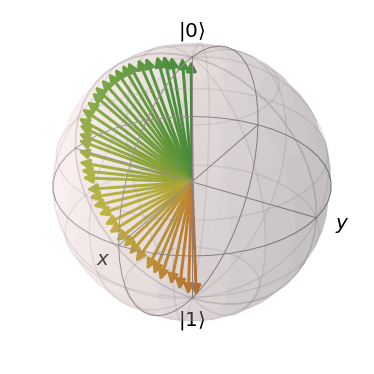

In [107]:
data = """0.0 0.02299999999999991 0.005600000000000049 1.0
0.07853981633974483 0.007600000000000051 -0.07620000000000005 0.996
0.15707963267948966 0.012399999999999967 -0.16279999999999994 0.99
0.23561944901923448 -0.0016000000000000458 -0.23219999999999996 0.9712000000000001
0.3141592653589793 0.008599999999999941 -0.2834 0.9536
0.39269908169872414 0.01639999999999997 -0.36760000000000004 0.9164000000000001
0.47123889803846897 0.007400000000000073 -0.44179999999999997 0.8897999999999999
0.5497787143782138 0.01200000000000001 -0.5267999999999999 0.8544
0.6283185307179586 0.00019999999999997797 -0.5831999999999999 0.8118000000000001
0.7068583470577035 -0.0013999999999999568 -0.6352 0.7474000000000001
0.7853981633974483 0.006399999999999961 -0.7032 0.718
0.8639379797371931 0.010199999999999987 -0.7605999999999999 0.6504000000000001
0.9424777960769379 0.014999999999999902 -0.8029999999999999 0.5724
1.0210176124166828 -0.01759999999999995 -0.8616 0.5022
1.0995574287564276 -0.010600000000000054 -0.8968 0.4161999999999999
1.1780972450961724 0.0242 -0.9226 0.3668
1.2566370614359172 0.033199999999999896 -0.9516 0.2876000000000001
1.335176877775662 -0.005800000000000027 -0.9772 0.20520000000000005
1.413716694115407 -0.012199999999999989 -0.9894 0.1277999999999999
1.4922565104551517 -0.016000000000000014 -0.998 0.06719999999999993
1.5707963267948966 -0.007800000000000029 -1.0 -0.021399999999999975
1.6493361431346414 -0.0038000000000000256 -0.996 -0.11639999999999995
1.7278759594743862 -0.008199999999999985 -0.9866 -0.18799999999999994
1.806415775814131 -0.0050000000000000044 -0.9708 -0.24619999999999997
1.8849555921538759 -0.012199999999999989 -0.9448 -0.3458
1.9634954084936207 -0.0043999999999999595 -0.923 -0.40900000000000003
2.0420352248333655 -0.0016000000000000458 -0.8902 -0.477
2.1205750411731104 -0.014800000000000035 -0.8394 -0.5409999999999999
2.199114857512855 -0.014599999999999946 -0.7856 -0.6138
2.2776546738526 -0.0048000000000000265 -0.7445999999999999 -0.6722
2.356194490192345 -0.012199999999999989 -0.6910000000000001 -0.7376
2.4347343065320897 -0.03059999999999996 -0.6317999999999999 -0.781
2.5132741228718345 -0.019399999999999973 -0.5820000000000001 -0.8358
2.5918139392115793 -0.00880000000000003 -0.5184 -0.8812
2.670353755551324 -0.020000000000000018 -0.4164 -0.9132
2.748893571891069 -0.021199999999999997 -0.35519999999999996 -0.9402
2.827433388230814 -0.0043999999999999595 -0.28680000000000005 -0.9606
2.9059732045705586 -0.02300000000000002 -0.2016 -0.9798
2.9845130209103035 -0.012199999999999989 -0.11880000000000002 -0.9926
3.0630528372500483 -0.0010000000000000009 -0.03380000000000005 -1.0
3.141592653589793 -0.018399999999999972 0.026799999999999935 -0.9988
""".split()

b = Bloch()
b.vector_color=colors
xs, zs = [], []
while len(data) > 0:
    data.pop(0)
    x, y, z = float(data.pop(0)), float(data.pop(0)), float(data.pop(0))
    norm = np.sqrt(x**2 + y**2 + z**2)
    x, y, z = x / norm, y / norm, z / norm
    xs.append(x); zs.append(z)
    b.add_vectors([x, y, z])
b.show()

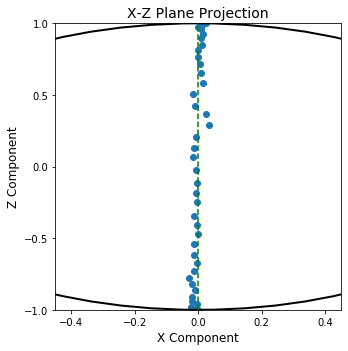

In [108]:
fig, ax = plt.subplots(figsize=(5.15, 5.27))
plt.gcf().subplots_adjust(left=0.13)
plt.scatter(xs, zs)
plt.axis([-0.45, 0.45, -1, 1])
#plt.plot(fit_xs, zs)
plt.xlabel('X Component', fontsize=12)
plt.ylabel('Z Component', fontsize=12)
plt.title('X-Z Plane Projection', fontsize=14)
plt.xticks([-0.4, -0.2, 0, .2, .4])
plt.yticks([-1, -.5, 0, .5, 1])

plt.plot([0, 0], [-1, 1], 'g--')

circle1 = plt.Circle((0, 0), 1, fill=False, linewidth=2)
plt.gcf().gca().add_artist(circle1)